# General setup

In [1]:
import os, sys, subprocess
import time
from glob import glob
import itertools
from functools import partial
import copy
import gc

import importlib
sys.path.insert(1, os.path.realpath('..'))
sys.path.insert(1, os.path.realpath('../../PyTorchShared'))
if "utils" not in sys.modules: import utils
else: importlib.reload(utils)
if "ml" not in sys.modules: import ml
else: importlib.reload(ml)
if "train" not in sys.modules: import train
else: importlib.reload(train)

# >>>
import ipynbname
nb_base = ipynbname.name().split('_')[0]
# <<<

import numpy as np

# >>>
from scipy import stats
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import ticker
import h5py
import csv
# <<<

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize
from torch.optim import SGD
from torch.optim.lr_scheduler import MultiStepLR
if not utils.is_notebook():
    import torch.multiprocessing as mp

In [2]:
# >>>
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
# <<<

Using cuda device


# Loading Data

In [3]:
transform = Compose([
    ToTensor(),
    Normalize((0.1307,), (0.3081,))
])

raw_train_dataset = MNIST(
    root="../../PyTorchShared/Datasets",
    train=True,
    download=True,
    transform=transform
)

raw_test_dataset = MNIST(
    root="../../PyTorchShared/Datasets",
    train=False,
    download=True,
    transform=transform
)

Shape of X [N, C, H, W]:  torch.Size([16, 1, 28, 28])
Shape of y:  torch.Size([16]) torch.int64
Shape of z:  torch.Size([16]) torch.int64


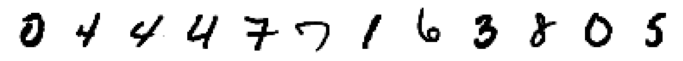

tensor([0, 4, 4, 4, 7, 7, 1, 6, 3, 8, 0, 5])
tensor([13,  5, 14, 10,  4, 17,  8,  9, 16,  2,  8, 15])


In [4]:
# >>>
preview_dataloader = DataLoader(
    ml.RelabeledSubset(raw_train_dataset, class_size=100,
                       target2_config=20, transform=transform),
    batch_size=16, shuffle=True)

X, y, z = next(iter(preview_dataloader))
print("Shape of X [N, C, H, W]: ", X.shape)
print("Shape of y: ", y.shape, y.dtype)
print("Shape of z: ", z.shape, z.dtype)
    
utils.plot_images(X.clamp_(-1, 1), num=12)
print(y[:12])
print(z[:12])
# <<<

# Training

In [6]:
HIDDEN_SIZE = 100
CLASS_SIZE = 100
BATCH_SIZE = 50
NUM_EPISODES = 10

DECORR_STRENGTH = 0.5
NUM_REPLICATES = 64
decorr_criteria = itertools.chain.from_iterable((
    itertools.repeat(None, NUM_REPLICATES),
    itertools.repeat(ml.decorr_criterion, NUM_REPLICATES),
    itertools.repeat(ml.halfcorr_criterion, NUM_REPLICATES)
))

MODE = ['testval', 'testsave']

train_dataset = (
    ml.RelabeledSubset,
    dict(dataset=raw_train_dataset, class_size=CLASS_SIZE,
         target2_config=NUM_EPISODES, transform=transform)
)
test_dataset = (
    ml.RelabeledSubset,
    dict(dataset=raw_test_dataset,
         target2_config='none', transform=transform)
)

model = (
    ml.TwoTargetMLP,
    dict(hidden_size=HIDDEN_SIZE,
         target1_size=10, target2_size=NUM_EPISODES,
         nonlinearity1=nn.Tanh(), nonlinearity2=nn.Tanh())
)

devices = itertools.cycle([torch.device('cuda', i)
                           for i in range(torch.cuda.device_count())])

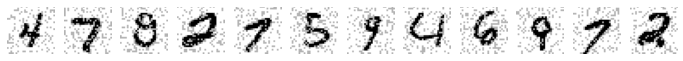

In [7]:
NUM_EPOCHS = 100
PRINT_EPOCHS = 0
LR_MILESTONES = [NUM_EPOCHS]
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 0

def NOISE_FN(data):
    mask = torch.rand_like(data)
    threshold = mask.quantile(0.2)
    mask = (mask - threshold > 0).float()
    noisy_data = data * mask
    return noisy_data

# >>>
X, _, _ = next(iter(preview_dataloader))
noisy_X = NOISE_FN(X)
utils.plot_images(noisy_X.clamp_(-1., 1.), num=12)
# <<<

In [8]:
kwargs_map = [dict(device=dev, decorr_criterion=param)
               for dev, param
               in zip(devices, decorr_criteria)]
kwargs_partial = dict(model=model,
                      mode=MODE,
                      train_dataset=train_dataset,
                      test_dataset=test_dataset,
                      decorr_strength=DECORR_STRENGTH,
                      noise_fn=NOISE_FN,
                      batch_size=BATCH_SIZE,
                      learning_rate=LEARNING_RATE,
                      lr_milestones=LR_MILESTONES,
                      num_epochs=NUM_EPOCHS,
                      print_epochs=PRINT_EPOCHS)
# >>>
print(kwargs_map[0])
print(len(list(kwargs_map)))
# <<<

{'device': device(type='cuda', index=0), 'decorr_criterion': None}
192


In [9]:
# >>>
i_train = 2*NUM_REPLICATES
print(model)
utils.start_timer()
result = train.two_target_train(
    **(kwargs_partial | {'print_epochs': 2}),
    **kwargs_map[i_train]
)
utils.end_timer_and_print()
# <<<

(<class 'ml.TwoTargetMLP'>, {'hidden_size': 100, 'target1_size': 10, 'target2_size': 10, 'nonlinearity1': Tanh(), 'nonlinearity2': Tanh()})
weight: 0.040461935102939606, X: 0.021875930950045586, z: 4, perm: 768
cuda:0   0)   loss:  2.180  2.321  4.477e+00   train: 0.272 0.100   test: 0.509 0.124
cuda:0   1)   loss:  1.717  2.308  2.708e+00   train: 0.657 0.123   test: 0.704 0.135
cuda:0   3)   loss:  0.989  2.269  2.077e+00   train: 0.817 0.156   test: 0.795 0.166
cuda:0   5)   loss:  0.661  2.237  1.795e+00   train: 0.877 0.178   test: 0.840 0.193
cuda:0   7)   loss:  0.491  2.208  1.621e+00   train: 0.902 0.203   test: 0.858 0.196
cuda:0   9)   loss:  0.385  2.179  1.551e+00   train: 0.934 0.226   test: 0.868 0.222
cuda:0  11)   loss:  0.313  2.149  1.453e+00   train: 0.953 0.233   test: 0.877 0.230
cuda:0  13)   loss:  0.260  2.113  1.431e+00   train: 0.965 0.259   test: 0.875 0.264
cuda:0  15)   loss:  0.217  2.071  1.391e+00   train: 0.973 0.288   test: 0.879 0.276
cuda:0  17)   l

In [10]:
if not utils.is_notebook():
    train_partial = partial(train.two_target_train, **kwargs_partial)
   
    MAX_PROCESSES = 2 * torch.cuda.device_count()
    
    if __name__ == "__main__":
        utils.start_timer()
        mp.set_start_method('spawn', force=True)
        
        num_processes = min(len(kwargs_map), MAX_PROCESSES)
        with mp.Pool(num_processes) as p:
            results = utils.kwstarmap(p, train_partial, kwargs_map)

        utils.end_timer_and_print()

In [11]:
# >>$ exclude from script to end of notebook
subprocess.call(["/bin/zsh", "-ic",
                 f"nb2script {nb_base}.ipynb"])

[NbConvertApp] Converting notebook accuracy.ipynb to script
[NbConvertApp] Writing 13460 bytes to accuracy_nb.py


0

In [12]:
nb_script = f"{nb_base}_nb.py"
%run -i $nb_script

weight: -0.09312581270933151, X: -0.1524391770362854, z: 2, perm: 502
weight: -0.050067782402038574, X: 0.26382604241371155, z: 9, perm: 945
weight: -0.06179262325167656, X: -0.002216803142800927, z: 2, perm: 108
weight: -0.051689933985471725, X: 0.038744084537029266, z: 8, perm: 276
weight: -0.0010548233985900879, X: 0.08030566573143005, z: 4, perm: 963
weight: -0.09353122860193253, X: 0.28092145919799805, z: 1, perm: 625
weight: 0.022707760334014893, X: 0.23710323870182037, z: 5, perm: 823
weight: 0.07198184728622437, X: 0.09486846625804901, z: 4, perm: 858
weight: 0.0173523910343647, X: 0.05105021968483925, z: 0, perm: 418
weight: 0.09667813777923584, X: 0.19692160189151764, z: 6, perm: 119
weight: 0.09199290722608566, X: 0.17570248246192932, z: 7, perm: 245
weight: -0.07763407379388809, X: -0.0885707288980484, z: 6, perm: 672
weight: -0.0640612244606018, X: 0.3151772916316986, z: 8, perm: 687
weight: -0.0036905051674693823, X: 0.06877882033586502, z: 2, perm: 484
weight: -0.0217758

# Accuracy

In [13]:
losses = np.array([result[0] for result in results])
train_accuracies = np.array([result[1] for result in results])
test_accuracies = np.array([result[2] for result in results])
y_activations = np.array([result[3][0] for result in results])
z_activations = np.array([result[3][1] for result in results])
y_weights = np.array([result[4][0] for result in results])
z_weights = np.array([result[4][1] for result in results])
y_biases = np.array([result[5][0] for result in results])
z_biases = np.array([result[5][1] for result in results])
class_targets = np.array([result[6][0] for result in results])
episode_targets = np.array([result[6][1] for result in results])

5.217332184755384e-32
5.254958444133408e-32
0.0017118188512476042
2.7723537233947783e-56
2.2516581042764106e-35
3.322546670413507e-25


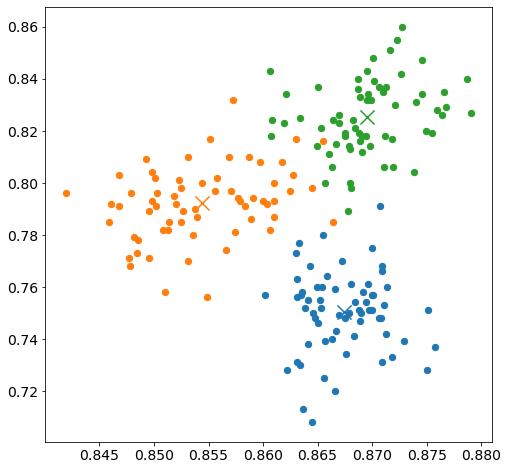

In [14]:
class_accuracies = test_accuracies[:,-1,0].reshape(-1, NUM_REPLICATES)
episode_accuracies = test_accuracies[:,-1,1].reshape(-1, NUM_REPLICATES)

mean_class_accs = class_accuracies.mean(-1)
mean_episode_accs = episode_accuracies.mean(-1)

fig, ax = plt.subplots(figsize=(8, 8))
colors = ('tab:blue', 'tab:orange', 'tab:green')
for accs1, accs2, color in zip(class_accuracies, episode_accuracies, colors):
    ax.scatter(accs1, accs2, s=40, color=color)
for accs1, accs2, color in zip(mean_class_accs, mean_episode_accs, colors):
    ax.scatter(accs1, accs2, s=200, marker="x", color=color)
    
print(stats.ttest_ind(class_accuracies[0], class_accuracies[1]).pvalue)
print(stats.ttest_ind(episode_accuracies[0], episode_accuracies[1]).pvalue)
print(stats.ttest_ind(class_accuracies[0], class_accuracies[2]).pvalue)
print(stats.ttest_ind(episode_accuracies[0], episode_accuracies[2]).pvalue)
print(stats.ttest_ind(class_accuracies[1], class_accuracies[2]).pvalue)
print(stats.ttest_ind(episode_accuracies[1], episode_accuracies[2]).pvalue)

# Influence

In [15]:
half = int(round(HIDDEN_SIZE/2))
start = 2 * NUM_REPLICATES
stop = None

In [16]:
y_activations = y_activations[start:stop]
z_activations = z_activations[start:stop]
y_weights = y_weights[start:stop]
z_weights = z_weights[start:stop]
y_biases = y_biases[start:stop]
z_biases = z_biases[start:stop]
class_targets = class_targets[start:stop]
episode_targets = episode_targets[start:stop]

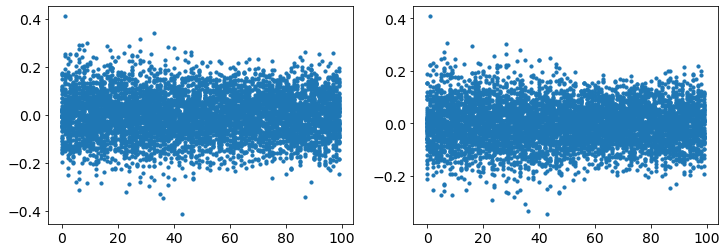

In [17]:
class_activations = y_activations.mean(1)
episode_activations = z_activations.mean(1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for c, e in zip(class_activations,
                episode_activations):
    axes[0].scatter(range(HIDDEN_SIZE), c, s=10, color='tab:blue')
    axes[1].scatter(range(HIDDEN_SIZE), e, s=10, color='tab:blue')
plt.show()

In [18]:
inds_by_class = [[np.where(targets == target)[0]
                  for target in np.unique(targets)]
                 for targets in class_targets]
variances = np.array([np.array([activations[inds].var(0)
                       for inds in inds_by_class]).mean(0)
                     for activations, inds_by_class
                     in zip(y_activations, inds_by_class)])

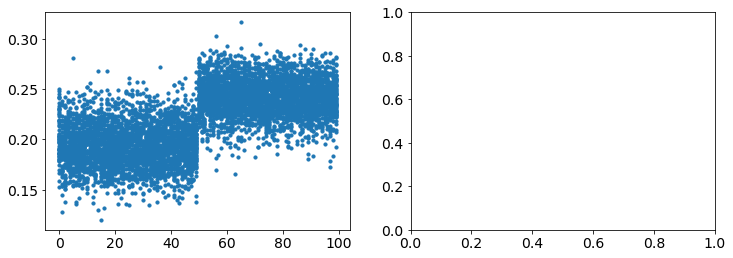

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for v in variances:
    axes[0].scatter(range(HIDDEN_SIZE), v, s=10, color='tab:blue')

In [26]:
y_logits_by_neuron = (np.expand_dims(y_activations.transpose(0,2,1), 3)
                      * np.expand_dims(y_weights.transpose(0,2,1), 2))
z_logits_by_neuron = (np.expand_dims(z_activations.transpose(0,2,1), 3)
                      * np.expand_dims(z_weights.transpose(0,2,1), 2))

y_logits = np.expand_dims(y_logits_by_neuron.sum(1)
                          + np.expand_dims(y_biases, 1), 1)
z_logits = np.expand_dims(z_logits_by_neuron.sum(1)
                          + np.expand_dims(z_biases, 1), 1)

y_logits_without_neuron = y_logits - y_logits_by_neuron
z_logits_without_neuron = z_logits - z_logits_by_neuron

In [27]:
class_accuracies = np.mean(y_logits.argmax(3)
                           == np.expand_dims(class_targets, 1), 2)
episode_accuracies = np.mean(z_logits.argmax(3)
                             == np.expand_dims(episode_targets, 1), 2)

class_acc_without_neuron = np.mean(y_logits_without_neuron.argmax(3)
                                   == np.expand_dims(class_targets, 1), 2)
episode_acc_without_neuron = np.mean(z_logits_without_neuron.argmax(3)
                                     == np.expand_dims(episode_targets, 1), 2)

class_influences = class_accuracies - class_acc_without_neuron
episode_influences = episode_accuracies - episode_acc_without_neuron

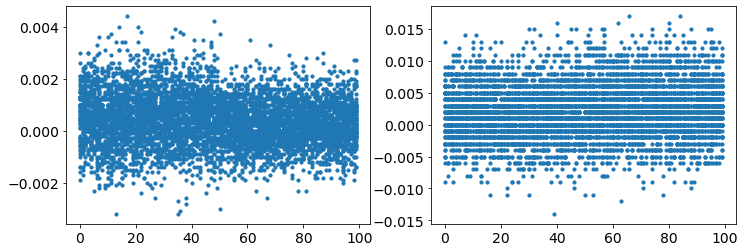

0.0004898125000000026 0.0002495937500000031 2.7307895117987514e-24
0.0017534374999999946 0.002625312499999993 1.0491169922253081e-17
0.0004999999999999449 0.000200000000000089 2.8956978035762007e-22


In [28]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for c, e in zip(class_influences, episode_influences):
    axes[0].scatter(range(HIDDEN_SIZE), c, s=10, color='tab:blue')
    axes[1].scatter(range(HIDDEN_SIZE), e, s=10, color='tab:blue')
plt.show()

class_influences0 = class_influences[:, :half].flatten()
class_influences1 = class_influences[:, half:].flatten()
episode_influences0 = episode_influences[:, :half].flatten()
episode_influences1 = episode_influences[:, half:].flatten()
print(class_influences0.mean(), class_influences1.mean(),
      stats.ttest_ind(class_influences0, class_influences1).pvalue)
print(episode_influences0.mean(), episode_influences1.mean(),
      stats.ttest_ind(episode_influences0, episode_influences1).pvalue)
print(np.median(episode_influences0), np.median(episode_influences1),
      stats.mannwhitneyu(episode_influences0, episode_influences1).pvalue)

In [29]:
if "h5file" in globals():
    h5file.close()
h5file = h5py.File(f"results/{nb_base}.h5", 'w')

h5file.create_dataset("losses", data=losses)
h5file.create_dataset("test_accuracies", data=test_accuracies)
h5file.create_dataset("class_activations", data=class_activations)
h5file.create_dataset("episode_activations", data=episode_activations)
h5file.create_dataset("variances", data=variances)
h5file.create_dataset("class_influences", data=class_influences)
h5file.create_dataset("episode_influences", data=episode_influences)

h5file.close()

In [23]:
y_activations_mean = y_activations.mean(1, keepdims=True)
z_activations_mean = z_activations.mean(1, keepdims=True)

y_logits_mean = (np.expand_dims(y_activations_mean.transpose(0,2,1), 3)
                  * np.expand_dims(y_weights.transpose(0,2,1), 2))
z_logits_mean = (np.expand_dims(z_activations_mean.transpose(0,2,1), 3)
                  * np.expand_dims(z_weights.transpose(0,2,1), 2))

y_logits_by_neuron = (np.expand_dims(y_activations.transpose(0,2,1), 3)
                      * np.expand_dims(y_weights.transpose(0,2,1), 2))
z_logits_by_neuron = (np.expand_dims(z_activations.transpose(0,2,1), 3)
                      * np.expand_dims(z_weights.transpose(0,2,1), 2))

y_logits_without_neuron = y_logits - y_logits_by_neuron + y_logits_mean
z_logits_without_neuron = z_logits - z_logits_by_neuron + z_logits_mean

In [24]:
class_acc_without_neuron = np.mean(y_logits_without_neuron.argmax(3)
                                   == np.expand_dims(class_targets, 1), 2)
episode_acc_without_neuron = np.mean(z_logits_without_neuron.argmax(3)
                                     == np.expand_dims(episode_targets, 1), 2)

class_influences = class_accuracies - class_acc_without_neuron
episode_influences = episode_accuracies - episode_acc_without_neuron

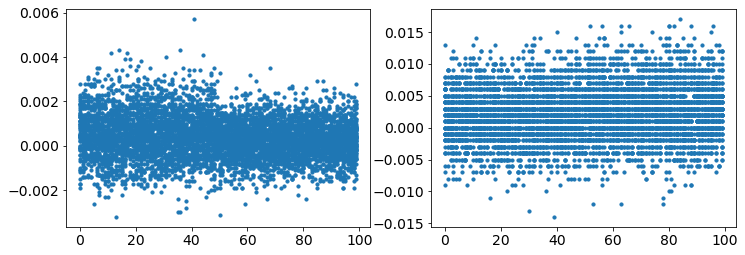

0.0005284687500000027 0.000251000000000003 1.7999844888851244e-31
0.0017684374999999946 0.0026428124999999937 5.8855611218115456e-18
0.0004999999999999449 0.000200000000000089 2.3474921352301378e-27


In [25]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for c, e in zip(class_influences, episode_influences):
    axes[0].scatter(range(HIDDEN_SIZE), c, s=10, color='tab:blue')
    axes[1].scatter(range(HIDDEN_SIZE), e, s=10, color='tab:blue')
plt.show()

class_influences0 = class_influences[:,:half].flatten()
class_influences1 = class_influences[:,half:].flatten()
episode_influences0 = episode_influences[:,:half].flatten()
episode_influences1 = episode_influences[:,half:].flatten()
print(class_influences0.mean(), class_influences1.mean(),
      stats.ttest_ind(class_influences0, class_influences1).pvalue)
print(episode_influences0.mean(), episode_influences1.mean(),
      stats.ttest_ind(episode_influences0, episode_influences1).pvalue)
print(np.median(class_influences0), np.median(class_influences1),
      stats.mannwhitneyu(class_influences0, class_influences1).pvalue)